In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import karateclub
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

In [5]:
import os
import matplotlib.pyplot as plt

In [6]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [8]:
genetox_outcomes = pd.read_csv(raw_dir/'genetox_outcomes.csv',index_col=0)
genetox_outcomes

,DTXSID,outcome,SMILES
0,DTXSID00148597,1,ClCC1=C2C=CC3=CC=CC4=C3C2=C(C=C1)C=C4
1,DTXSID00157169,1,CCNC1=C(O)C(Cl)=CC(=C1)[N+]([O-])=O
2,DTXSID00159204,0,CCO[Si](C)(CCCCl)OCC
3,DTXSID00160734,0,NCCCC(O)(P(O)(O)=O)P(O)(O)=O
4,DTXSID00162834,0,CNCC1=CC=CC2=CC=CC=C12
...,...,...,...
5398,DTXSID90890477,0,COC1=C(NC2=NC(SCCCS(O)(=O)=O)=NC(SCCCS(O)(=O)=...
5399,DTXSID90890619,0,OC(=O)C1=C(C=CC=C1)N=NC1=C2C=CC=CC2=CC=C1O
5400,DTXSID90890811,0,CCCCCCCCCC1=CC2=CC=CC=C2C(=C1CCCCCCCCC)S(O)(=O)=O
5401,DTXSID90891080,0,CC1=C(Cl)C=C(N=NC2=C(O)C=CC3=CC=CC=C23)C(=C1)S...


In [9]:

smile_outcome_dict = dict(zip(list(genetox_outcomes.SMILES),list(genetox_outcomes.outcome)))

In [10]:
fps = []
for smile in list(smile_outcome_dict.keys()):
    mol = Chem.MolFromSmiles(smile)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)))

X_fps = np.array(fps)
y = list(smile_outcome_dict.values())

knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score))

In [11]:
print(cv['test_score'].mean())

0.6650191738817537


In [12]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.7315262876338282


In [13]:
def one_hot_encoding(x, permitted_list):

    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

def get_bond_features(bond, 
                      use_stereochemistry = True):
  
    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
 
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_val))

    return data_list


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv,Linear,global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

In [15]:
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [16]:
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(list(genetox_outcomes.SMILES),list(genetox_outcomes.outcome))
training_data, validation_data = data_list[:4000],data_list[4000:]

In [26]:
len(data_list)

5403

In [27]:
len(val_embeddings)

1403

In [53]:
[e for e in genetox_outcomes.iloc[4000:]['SMILES'] if 'N(=O)' in e]

['CC1=CN(=O)=C2C=CC=CC2=C1[N+]([O-])=O']

In [54]:
genetox_outcomes.iloc[4000:][genetox_outcomes.iloc[4000:]['SMILES'] == 'CC1=CN(=O)=C2C=CC=CC2=C1[N+]([O-])=O']

,DTXSID,outcome,SMILES
4787,DTXSID8074944,1,CC1=CN(=O)=C2C=CC=CC2=C1[N+]([O-])=O


In [17]:
class GCN(torch.nn.Module):
    
    def __init__(self):
        
        super(GCN,self).__init__()
        torch.manual_seed(12345)

        # Convolutional layers
        self.conv1 = GATv2Conv(79,64)
        self.conv2 = GATv2Conv(64,64)
        self.conv3 = GATv2Conv(64,128)

        # Output layer
        self.lin1 = Linear(128,2)
        

    def forward(self,x,edge_index,batch_index):
        x = self.conv1(x,edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        x = x.relu()
        x = self.conv3(x,edge_index)
        x = x.relu()
        
        embedding = global_mean_pool(x,batch_index)
        x = global_mean_pool(x,batch_index)

        x = self.lin1(x)
    
        return(x,embedding)
    
print(GCN())

GCN(
  (conv1): GATv2Conv(79, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 128, heads=1)
  (lin1): Linear(128, 2, bias=True)
)


In [18]:
def train():
    model.train()

    for data in train_loader:
        out,embedding = model(data.x,data.edge_index,data.batch)
        loss = criterion(out,data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()

    preds,truths = [],[]
    
    for data in loader:
        out,embedding = model(data.x,data.edge_index,data.batch)
        pred = out.argmax(dim=1).detach().numpy()
        y = data.y.detach().numpy()
        return roc_auc_score(y,pred)

train_loader = DataLoader(training_data,batch_size=64,shuffle=True)
test_loader = DataLoader(validation_data,batch_size=64,shuffle=False)
        
model = GCN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train for e epochs
for e in range(50):
    train()
    train_auc = test(train_loader)
    test_auc = test(test_loader)
    print('Epoch {}: Training AUC: {:.3f}  Testing AUC: {:.3f}'.format(e+1,train_auc,test_auc))


Epoch 1: Training AUC: 0.500  Testing AUC: 0.500
Epoch 2: Training AUC: 0.572  Testing AUC: 0.528
Epoch 3: Training AUC: 0.634  Testing AUC: 0.529
Epoch 4: Training AUC: 0.595  Testing AUC: 0.545
Epoch 5: Training AUC: 0.691  Testing AUC: 0.634
Epoch 6: Training AUC: 0.572  Testing AUC: 0.517
Epoch 7: Training AUC: 0.701  Testing AUC: 0.551
Epoch 8: Training AUC: 0.625  Testing AUC: 0.517
Epoch 9: Training AUC: 0.687  Testing AUC: 0.562
Epoch 10: Training AUC: 0.703  Testing AUC: 0.551
Epoch 11: Training AUC: 0.625  Testing AUC: 0.523
Epoch 12: Training AUC: 0.671  Testing AUC: 0.540
Epoch 13: Training AUC: 0.638  Testing AUC: 0.551
Epoch 14: Training AUC: 0.625  Testing AUC: 0.523
Epoch 15: Training AUC: 0.653  Testing AUC: 0.568
Epoch 16: Training AUC: 0.714  Testing AUC: 0.523
Epoch 17: Training AUC: 0.770  Testing AUC: 0.529
Epoch 18: Training AUC: 0.709  Testing AUC: 0.563
Epoch 19: Training AUC: 0.659  Testing AUC: 0.535
Epoch 20: Training AUC: 0.658  Testing AUC: 0.540
Epoch 21:

In [19]:
val_embeddings,val_preds,val_truths = [],[],[]
for g in validation_data:
    out,embedding = model(g.x,g.edge_index,None)
    val_embeddings.append(embedding.detach().numpy()[0])
    val_preds.append(out.detach().numpy()[0])
    val_truths.append(int(g.y))

In [37]:
pd.DataFrame(val_embeddings, index = val_dict.keys())

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
DTXSID7026946,0.246817,0.00000,0.000000,0.231699,0.361634,0.657249,0.047328,0.008380,0.007981,0.456023,...,0.469329,0.016875,0.183736,0.121407,0.000000,0.306120,0.000000,0.296645,0.071516,0.205657
DTXSID7027041,0.246950,0.00000,0.000000,0.328335,0.454361,0.802805,0.131106,0.000000,0.000000,0.533766,...,0.564435,0.000000,0.350090,0.162124,0.000000,0.446471,0.000000,0.410881,0.181743,0.338820
DTXSID7027043,0.033494,0.00000,0.000000,0.028636,0.155566,0.305002,0.000000,0.000000,0.000000,0.247303,...,0.183519,0.000000,0.000000,0.125247,0.000000,0.083952,0.000000,0.010310,0.000000,0.041252
DTXSID7027047,0.082099,0.00000,0.000000,0.280656,0.277354,0.607004,0.071530,0.003450,0.000000,0.388850,...,0.362452,0.004943,0.294021,0.124214,0.000000,0.411398,0.000000,0.294846,0.104686,0.232207
DTXSID7027049,0.327457,0.16075,0.186379,0.318634,0.266723,0.479474,0.177429,0.000000,0.000000,0.271771,...,0.330118,0.000000,0.422033,0.235812,0.000000,0.535762,0.000000,0.324601,0.303973,0.225723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID90890477,0.121968,0.00000,0.000000,0.197670,0.368277,0.549654,0.144148,0.003955,0.053040,0.409696,...,0.252034,0.003610,0.402928,0.289079,0.104406,0.451879,0.000243,0.324735,0.121450,0.225935
DTXSID90890619,0.091226,0.00000,0.000000,0.045026,0.135216,0.323678,0.004531,0.004587,0.247796,0.132659,...,0.174469,0.011701,0.065657,0.217641,0.124729,0.273610,0.064028,0.153454,0.003081,0.028896
DTXSID90890811,0.119858,0.00000,0.000000,0.411965,0.392125,1.005897,0.102543,0.007709,0.064471,0.551285,...,0.457312,0.030657,0.677242,0.141247,0.008633,0.624476,0.034064,0.471406,0.151317,0.433037
DTXSID90891080,0.144392,0.00000,0.000000,0.100628,0.252023,0.404230,0.065356,0.007578,0.171236,0.235484,...,0.218752,0.011371,0.154464,0.264364,0.080974,0.324081,0.043556,0.215382,0.045909,0.105914


In [40]:
val_set = genetox_outcomes.iloc[4000:]
val_set = val_set.set_index('DTXSID')

In [44]:
val_embeddings_df = pd.DataFrame(val_embeddings, index = val_dict.keys())

In [45]:
from scipy.spatial.distance import pdist, squareform

In [46]:
D_cos = pd.DataFrame(squareform(pdist(val_embeddings_df, 'cosine')), index = val_dict.keys(), columns = val_dict.keys())

<Axes: >

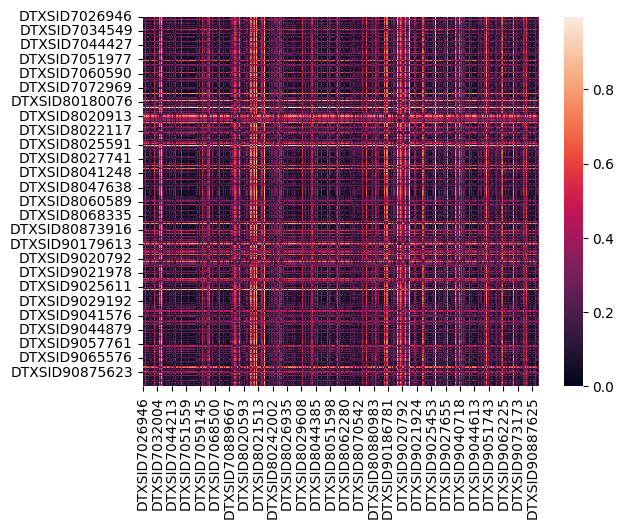

In [48]:
sns.heatmap(D_cos)

In [49]:
def transform_matrix(df):
    a = df.where(np.triu(np.ones(df.shape)).astype('bool'))
    a = df.stack().reset_index()
    a = a.where(a.iloc[:,0] != a.iloc[:,1])
    a = a.dropna()
    a.columns = ['target', 'source', 'jaccard']
    a = a.sort_values(by = 'jaccard', ascending = False)
    a['bins'] = pd.cut(x = a['jaccard'], bins = [-0.000001,0.1,0.3, 0.5,0.7,1,1.5,2])
    return a, a['bins'].value_counts(dropna = False, normalize = True)

In [50]:
transform_matrix(D_cos)[1]

bins
(0.1, 0.3]       0.444632
(-1e-06, 0.1]    0.216700
(0.3, 0.5]       0.211647
(0.5, 0.7]       0.083058
(0.7, 1.0]       0.043963
(1.0, 1.5]       0.000000
(1.5, 2.0]       0.000000
Name: proportion, dtype: float64

In [57]:
D_cos.loc['DTXSID8074944'].reset_index().sort_values(by = 'DTXSID8074944', ascending = True)

,index,DTXSID8074944
787,DTXSID8074944,0.000000
1311,DTXSID9067980,0.053174
365,DTXSID8020751,0.057090
357,DTXSID8020593,0.079914
291,DTXSID70875601,0.080007
...,...,...
692,DTXSID8059392,0.870688
563,DTXSID8029991,0.871816
533,DTXSID8027533,0.871816
1177,DTXSID9044742,0.872670


In [63]:
{k:v for k,v in val_dict.items() if k in {'DTXSID8074944', 'DTXSID9067980','DTXSID8020751','DTXSID8020593','DTXSID70875601'}}

{'DTXSID70875601': 1,
 'DTXSID8020593': 1,
 'DTXSID8020751': 1,
 'DTXSID8074944': 1,
 'DTXSID9067980': 0}

In [36]:
val_dict = {k:v for k, v in zip(genetox_outcomes.iloc[4000:]['DTXSID'], genetox_outcomes.iloc[4000:]['outcome'])}

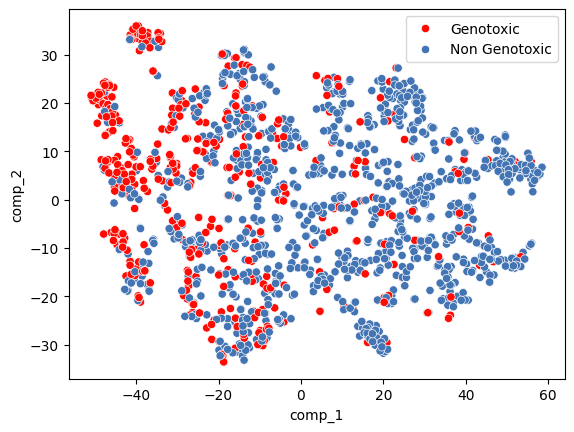

In [21]:
tsne = TSNE(n_components=2,random_state=42)
z = tsne.fit_transform(np.array(val_embeddings))

df = pd.DataFrame()
tsne_y = []
for t in val_truths:
    if t == 1: tsne_y.append('Genotoxic')
    if t == 0: tsne_y.append('Non Genotoxic')
df['tsne_y'] = tsne_y
df['comp_1'] = z[:,0]
df['comp_2'] = z[:,1]
colors = ["#FF0B04","#4374B3"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='comp_1',y='comp_2',hue=df.tsne_y.tolist(),data=df)
plt.savefig(figures_dir/'GCN_embedding_171224.png', dpi = 300)

In [22]:
gcn_knn = KNeighborsClassifier(n_jobs=-1)
gcn_knn_cv = cross_validate(gcn_knn,val_embeddings,val_truths,cv=5,scoring=make_scorer(roc_auc_score))
print('AUC score for KNN classifcation of genotoxicity over 5-fold CV using GCN molecular graph embeddings: {:.3f}'.format(np.mean(gcn_knn_cv['test_score'])))


AUC score for KNN classifcation of genotoxicity over 5-fold CV using GCN molecular graph embeddings: 0.659


In [23]:
gcn_lr = LogisticRegression(n_jobs=-1)
gcn_lr_cv = cross_validate(gcn_lr,val_embeddings,val_truths,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print('AUC score for logistic regression classifcation of genotoxicity over 5-fold CV using GCN molecular graph embeddings: {:.3f}'.format(np.mean(gcn_lr_cv['test_score'])))

AUC score for logistic regression classifcation of genotoxicity over 5-fold CV using GCN molecular graph embeddings: 0.778
